# Local-in-time rerun

In [4]:
%load_ext autoreload
import tools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import time
%load_ext snakeviz
import os   
import pickle
import pprint
from lit import *
%autoreload 2



# Plotting and post-processing

In [ ]:



plt.semilogy(hist_time,np.array(hist_th_hm1),label= 'H^-1')
plt.semilogy(hist_time,np.array(hist_th_l2),label= 'L^2')
plt.semilogy(hist_time,np.array(hist_th_h1),label= 'H^1')
hm1= hist_hm1[0]
h1 = st.h1norm(hist_th[0])
l2 = hist_l2[0]
t = time_array
pred = hm1*np.exp(-t-1/(2.*Pe)*h1**2./l2**2.*(np.exp(2.*t)-1.))
#pred = hm1*np.exp(-t)
plt.semilogy(time_array, pred, label= 'Lower Bound')
plt.legend()
#plt.xlim([0,0.5])
plt.ylim([1e-6,1e2])
plt.show()


lam = (2.*np.pi*np.array(hist_th_hm1)/np.array(hist_th_l2))
plt.semilogy(hist_time,lam,label= r'$\lambda$')
plt.legend()
#plt.xlim([0,0.5])
#plt.ylim([1e-6,1e2])
plt.show()

plt.semilogy(hist_time,(2.*np.pi)**-0.5*lam/(1./(Pe)**0.5),label= r'$\lambda / \lambda_B$')
plt.legend()
#plt.xlim([0,0.5])
#plt.ylim([1e-6,1e2])
plt.show()

plt.semilogy(hist_time,np.array(hist_u_h1),label= 'velocity H^1')
plt.semilogy(hist_time,np.array(hist_u_l2),label= 'velocity L^2')
#plt.semilogy(hist_time,[np.amax(np.array(u)) for u in hist_u],label= 'velocity L^\infty')
plt.legend()
#plt.xlim([0,0.5])
#plt.ylim([1e-6,1e2])
plt.show()


r= np.zeros(len(hist_time))
for i in range(len(hist_time)):
    if i == 0 :
        delta_t = hist_time[i+1]-hist_time[i]
        dhm1_dt = (hist_th_hm1[i+1]-hist_th_hm1[i])/delta_t
        r[i] = dhm1_dt/hist_th_hm1[i]
        
    if i > 0 and i < len(hist_time)-1:
        delta_t = hist_time[i+1]-hist_time[i-1]
        dhm1_dt = (hist_th_hm1[i+1]-hist_th_hm1[i-1])/delta_t
        r[i] = dhm1_dt/hist_th_hm1[i]
        
    if i == len(hist_time)-1:
        delta_t = hist_time[i]-hist_time[i-1]
        dhm1_dt = (hist_th_hm1[i]-hist_th_hm1[i-1])/delta_t
        r[i] = dhm1_dt/hist_th_hm1[i]
        
plt.semilogy(hist_time,-r,label= 'r(t)')
plt.legend()
plt.show()

# Testing Convergence

In [ ]:
s = []
ss=[]
N= 256
L = 1.0
M_list = [8,16,32,64] 
T = 0.01
Pe = 512

dt_list = []
for M in M_list:
    s.append(sim(N = N, M = M, T =T, L = L,save_every =1,
                 T_kick=0.01, Pe = Pe, plot=False))
    dt_list.append(T/M)
error_list = []
st = tools.ScalarTool(N,L)
for i in range(len(M_list)-1):
        error_list.append(st.l2norm(s[i].hist_th[-1] - s[-1].hist_th[-1]))

error_array = np.array(error_list)
dt_array = np.array(dt_list)
print(st.l2norm(s[-3].hist_th[-1] - s[-2].hist_th[-1]))
print(st.l2norm(s[-2].hist_th[-1] - s[-1].hist_th[-1]))
R = st.l2norm(s[-3].hist_th[-1] - s[-2].hist_th[-1])/st.l2norm(s[-2].hist_th[-1] - s[-1].hist_th[-1])
p = np.log(R)/np.log(2)
print('p = ', p)

In [ ]:
plt.loglog(dt_array[:-1], error_array, label = 'error')
plt.loglog(dt_array, error_array[0]*(dt_array/dt_array[0])**4, label = 'expected')
plt.legend()
plt.show()
print(error_array)
print(dt_array)
print([s[i].hist_time[-1] for i in range(len(s))])

In [ ]:
st.l2norm(s[2].hist_th[0] - s[1].hist_th[1])

In [ ]:
gamma = 1.0
N = 128
L= 1.0
kappa = 0.0
st = tools.ScalarTool(N,L)
vt = tools.VectorTool(N,L)
ftype = np.float64
T=0.32
M_list=[32,64,128,256,512]


def f(th,u):
    return -1.0*np.sum(vt.dealias(u)*st.grad(st.dealias(th)),0) + kappa * st.lap(st.dealias(th))
    #return -1.0*np.sum(u*st.grad(th),0) + kappa * st.lap(th)
def u_lit(th0):
    u_lit = st.dealias(th0) * vt.dealias(st.grad_invlap(th0))
    #print(vt.l2norm(u_lit))
    u_lit = - vt.invlap(vt.div_free_proj(u_lit))
    u_lit = gamma * L * u_lit / st.l2norm(vt.curl(u_lit))
    return u_lit

# def f_lit(th):
#     u_kick = np.zeros((2,N,N),dtype = ftype)
#     u_kick[0,:,:] = np.sin(2.*np.pi*X[1]/L)
#     return f(th,u_kick)

def f_lit(th):
    return f(th,u_lit(th))


for dt_kick in [0.1,0.01,0.001,0.0001,0.0000000001]:

    th_list = []
    th =np.sin(2*np.pi*st.X[0]/L)
    u_kick = np.zeros((2,N,N),dtype = ftype)
    u_kick[0,:,:] = np.sin(2.*np.pi*st.X[1]/L)
    th_kick= th + dt_kick*f(th,u_kick)

    dt_list = []
    for M in M_list:
        dt = T/M
        th =copy.copy(th_kick)
        for i in range(M):
            k1 = f_lit(th)
            k2 = f_lit(th + 0.5*dt*k1)
            k3 = f_lit(th + 0.5*dt*k2)
            k4 = f_lit(th + dt*k3)
            th = th + dt*(1./6.)*(k1 + 2.*k2 + 2.*k3 + k4)
            #th = th + dt*k1
        th_list.append(th)
        dt_list.append(dt)


    error_list = []
    for i in range(0,len(M_list)-1):
        error_list.append(st.l2norm(th_list[i]-th_list[-1]))
    plt.figure()
    plt.loglog(dt_list[:-1],error_list)
    plt.loglog(dt_list,np.array(dt_list)**4)
    #plt.ylim(1e0,1e2)
    plt.show()

In [ ]:
dt_kick = 0.001
th =np.sin(2*np.pi*st.X[0]/L)
u_kick = np.zeros((2,N,N),dtype = ftype)
u_kick[0,:,:] = np.sin(2.*np.pi*X[1]/L)


th= th + dt_kick*f(th,u_kick)

u_lit = st.dealias(th) * vt.dealias(st.grad_invlap(th))
print(vt.l2norm(u_lit))
u_lit = - vt.invlap(vt.div_free_proj(u_lit))
print(vt.l2norm(u_lit))
u_lit = gamma * L * u_lit / st.l2norm(vt.curl(u_lit))
print(vt.h1norm(u_lit))   

In [ ]:
vt.l2norm(u1-u0)

In [ ]:
pickle_file = "/Volumes/Transcend/LIT/output-pe=1024/pe=1024.pkl"

with open(pickle_file, 'rb') as f:
    d = pickle.load(f, encoding='latin1') 


In [ ]:
time_1024,th_1024 = d

In [ ]:
N=256
L=1.0
st = tools.ScalarTool(N,L)
st.plot(th_1024[-1])

In [ ]:
N=256
L=1.0
Pe = 1024
T=time_1024[-1]
dt = 0.001
sim_1024 = sim(N = N, dt = dt, T =T, L = L, Pe = Pe, save_every = 100, plot=True)

In [ ]:
st.plot(th_1024[-1])
plt.show()
st.plot(sim_1024.hist_th[-1])
plt.show()

In [ ]:
st.hm1norm(th_1024[-1])

In [ ]:
st.hm1norm(sim_1024.hist_th[-1])

In [ ]:
## time_1024[-1]2

In [ ]:
plt.semilogy(sim_1024.hist_time,np.array(sim_1024.hist_th_hm1))
plt.semilogy(time_1024, [ st.hm1norm(th) for th in th_1024 ])
plt.show()

In [ ]:
plt.semilogy(sim_1024.hist_time,np.array(sim_1024.hist_th_hm1))
plt.semilogy(time_1024, [ st.hm1norm(th) for th in th_1024 ])
plt.show()

In [ ]:
pickle_file = "output-pe=128.0-M=26/pe=128.0.pkl"

with open(pickle_file, 'rb') as f:
    d = pickle.load(f, encoding='latin1') 

In [ ]:
d.hist_time

In [ ]:
sim(constraint = "energy",T=0.3,M=1000,N=64,plot=True,Pe=32)

# Test convergence for fixed Pe and series of M values

In [54]:
M_list = [4096, 8192, 16384] 
Pe = 512.0
s = []
folder = "/Volumes/Transcend/LIT_2_28_18_4PM_ENERGY/"
for M in M_list:
    pickle_file = folder + "output-pe="+str(Pe)+"-M="+str(M)+"/pe="+str(Pe)+"-M="+str(M) +".pkl"

    with open(pickle_file, 'rb') as f:
        s.append(pickle.load(f, encoding='latin1'))
    

N = s[0].N
L = s[0].L
dt_list = [item.T/item.M for item in s]
error_list = []
st = tools.ScalarTool(N,L)
for i in range(len(M_list)-1):
        error_list.append(st.l2norm(s[i].hist_th[-1] - s[2].hist_th[-1]))

error_array = np.array(error_list)
dt_array = np.array(dt_list)
print(st.l2norm(s[0].hist_th[-1] - s[1].hist_th[-1]))
print(st.l2norm(s[1].hist_th[-1] - s[2].hist_th[-1]))
R = st.l2norm(s[0].hist_th[-1] - s[1].hist_th[-1])/st.l2norm(s[1].hist_th[-1] - s[2].hist_th[-1])
p = np.log(R)/np.log(2)
print('p = ', p)

1.75145375813e-06
1.14418968192e-07
p =  3.93615475391


In [13]:
a = np.fft.fftn(s[2].hist_th[-1])

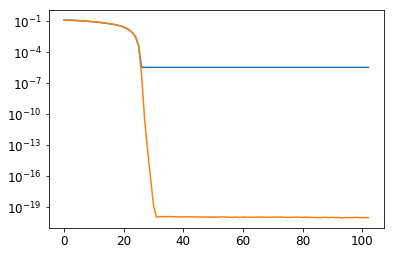

In [100]:
plt.semilogy([st.hm1norm((st.subtract_mean(s[2].hist_th[i])))for i in range(len(s[2].hist_th))])
plt.semilogy([st.hm1norm(st.dealias(st.subtract_mean(s[2].hist_th[i])))for i in range(len(s[2].hist_th))])
plt.show()

In [ ]:
Pe_dict[128] = [100,200,300]
Pe_dict[64] = [50,300,600]

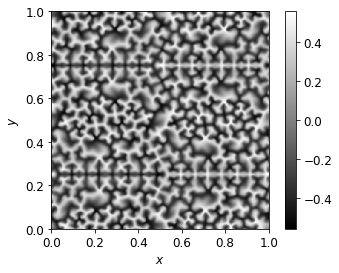

512

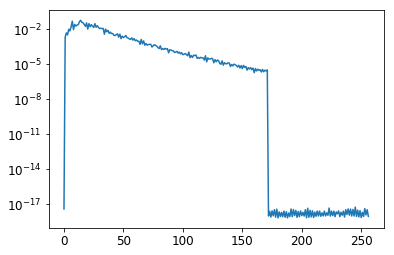

In [89]:
scalar = st.dealias(s[2].hist_th[24])
#scalar = s[2].hist_th[20]
st.plot(st.dealias(scalar))
plt.show()
k,spec = st.get_spectrum(scalar)
plt.semilogy(k,spec)
s[2].N

In [75]:
k = 2*np.pi*st.kmax_dealias 
print(2*np.pi/k)

0.005836575875486382


In [71]:
1./N

0.001953125

In [44]:
Pe = 512
s = []
folder = "/Volumes/Transcend/Google Drive/pde2/"
pickle_file = folder + "output-pe="+str(Pe)+"/pe="+str(Pe)+".pkl"

with open(pickle_file, 'rb') as f:
    time,th = pickle.load(f, encoding='latin1')

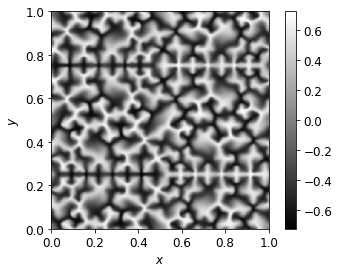

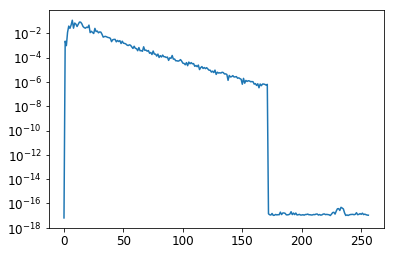

In [87]:
scalar = th[90]
st.plot(scalar)
plt.show()
k,spec = st.get_spectrum(scalar)
plt.semilogy(k,spec)

In [ ]:
M = 164
Pe = 128.0


pickle_file = "output-pe="+str(Pe)+"-M="+str(M)+"/pe="+str(Pe)+"-M="+str(M) +".pkl"

with open(pickle_file, 'rb') as f:
    s = pickle.load(f, encoding='latin1')
    


In [93]:
time

array([ 0.        ,  0.00501253,  0.01002506,  0.01503759,  0.02005013,
        0.02506266,  0.03007519,  0.03508772,  0.04010025,  0.04511278,
        0.05012531,  0.05513784,  0.06015038,  0.06516291,  0.07017544,
        0.07518797,  0.0802005 ,  0.08521303,  0.09022556,  0.0952381 ,
        0.10025063,  0.10526316,  0.11027569,  0.11528822,  0.12030075,
        0.12531328,  0.13032581,  0.13533835,  0.14035088,  0.14536341,
        0.15037594,  0.15538847,  0.160401  ,  0.16541353,  0.17042607,
        0.1754386 ,  0.18045113,  0.18546366,  0.19047619,  0.19548872,
        0.20050125,  0.20551378,  0.21052632,  0.21553885,  0.22055138,
        0.22556391,  0.23057644,  0.23558897,  0.2406015 ,  0.24561404,
        0.25062657,  0.2556391 ,  0.26065163,  0.26566416,  0.27067669,
        0.27568922,  0.28070175,  0.28571429,  0.29072682,  0.29573935,
        0.30075188,  0.30576441,  0.31077694,  0.31578947,  0.32080201,
        0.32581454,  0.33082707,  0.3358396 ,  0.34085213,  0.34

In [94]:
s[2].hist_th_time

[0.0,
 0.0001220703125,
 0.02001953125,
 0.0399169921875,
 0.059814453125,
 0.0797119140625,
 0.099609375,
 0.1195068359375,
 0.139404296875,
 0.1593017578125,
 0.17919921875,
 0.1990966796875,
 0.218994140625,
 0.2388916015625,
 0.2587890625,
 0.2786865234375,
 0.298583984375,
 0.3184814453125,
 0.33837890625,
 0.3582763671875,
 0.378173828125,
 0.3980712890625,
 0.41796875,
 0.4378662109375,
 0.457763671875,
 0.4776611328125,
 0.49755859375,
 0.5174560546875,
 0.537353515625,
 0.5572509765625,
 0.5771484375,
 0.5970458984375,
 0.616943359375,
 0.6368408203125,
 0.65673828125,
 0.6766357421875,
 0.696533203125,
 0.7164306640625,
 0.736328125,
 0.7562255859375,
 0.776123046875,
 0.7960205078125,
 0.81591796875,
 0.8358154296875,
 0.855712890625,
 0.8756103515625,
 0.8955078125,
 0.9154052734375,
 0.935302734375,
 0.9552001953125,
 0.97509765625,
 0.9949951171875,
 1.014892578125,
 1.0347900390625,
 1.0546875,
 1.0745849609375,
 1.094482421875,
 1.1143798828125,
 1.13427734375,
 1.15417